# Notebook of comparison VAE and geometric VAE

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

from scCFM.models.base.vae import VAE
from scCFM.models.base.geometric_vae import GeometricNBVAE, GeometricNBAE
from scCFM.datamodules.sc_datamodule import scDataModule

from scCFM.models.manifold.geometry_metrics import compute_all_metrics

import sys
sys.path.insert(0, "../..")
from notebooks.utils import real_reconstructed_cells_adata

from paths import PROJECT_FOLDER
import torch
import anndata

import scipy

import seaborn as sns

**Util functions**

In [3]:
def make_joint_df(arrays, labels):
    all_arrays = np.concatenate(arrays)
    all_labels = []
    for i,lab in enumerate(labels):
        all_labels += [lab for _ in range(len(arrays[i]))]
    return pd.DataFrame({"values": all_arrays,
                         "labels": all_labels})

## Initialize the two different configurations 

General module hparams

In [4]:
datamodule={'path': '/nfs/homedirs/pala/scCFM/project_dir/data/eb/processed/eb_phate.h5ad', 
            'x_layer': 'X_norm', 
            'cond_keys': ['experimental_time', 'leiden'],
            'use_pca': False, 
            'n_dimensions': None, 
            'train_val_test_split': [1], 
            'batch_size': 128, 
            'num_workers': 2}


# Initialize datamodule
datamodule = scDataModule(**datamodule)

### Model config VAE

In [7]:
model_vae={
       'in_dim': datamodule.in_dim,
       'n_epochs_anneal_kl': 1000, 
       'kl_weight': None, 
       'likelihood': 'nb', 
       'dropout': False, 
       'learning_rate': 0.001, 
       'dropout_p': False, 
       'model_library_size': True, 
       'batch_norm': True, 
       'kl_warmup_fraction': 0.1, 
       'hidden_dims': [256, 10]}
        
geometric={'compute_metrics_every': 1, 
           'use_c': True, 
           'l2': True, 
           'eta_interp': 0, 
           'interpolate_z': False, 
           'start_jac_after': 0, 
           'fl_weight': 0.1,
           'detach_theta': True}

In [8]:
vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae)
geometric_vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae)

In [9]:
# vae = GeometricNBAE(**geometric, vae_kwargs=model_ae)
# geometric_vae = GeometricNBAE(**geometric, vae_kwargs=model_ae)

In [10]:
vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/eb/best_model_vae_lib.ckpt")["state_dict"])
geometric_vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/eb/best_model_geometric_lib.ckpt")["state_dict"])

<All keys matched successfully>

### Compute UMAPs

In [13]:
adata_vae_amortized_real, adata_vae_z, adata_vae_mu = real_reconstructed_cells_adata(vae, datamodule, process_amortized_adata=True, log1p=True, vae=True).values()
adata_geometric_amortized_real, adata_geometric_z, adata_geometric_mu = real_reconstructed_cells_adata(geometric_vae, datamodule, process_amortized_adata=True, log1p=True, vae=True).values()

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/a

In [14]:
adata_vae_z.obs["leiden"] = adata_vae_z.obs["leiden"].astype("category")
adata_geometric_z.obs["leiden"] = adata_geometric_z.obs["leiden"].astype("category")

Plot the UMAP results

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


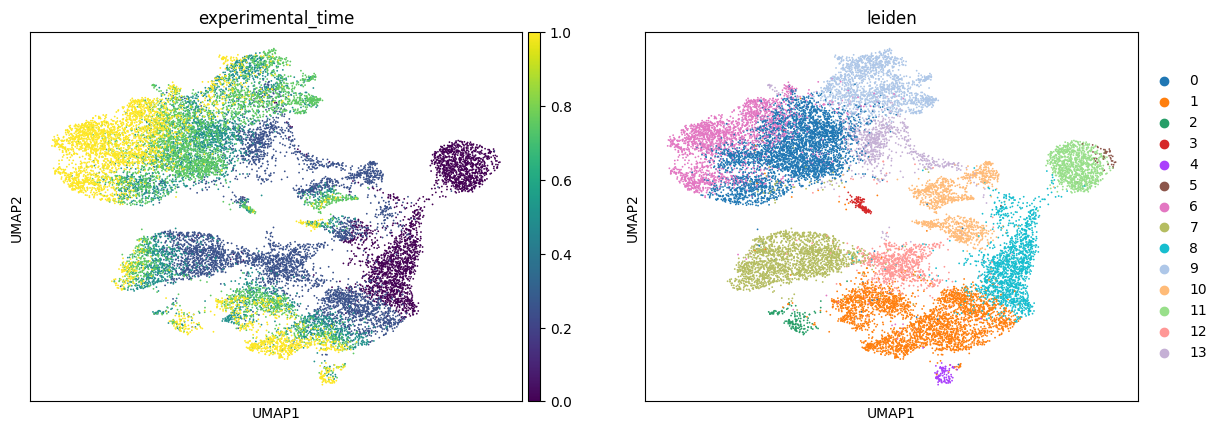

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


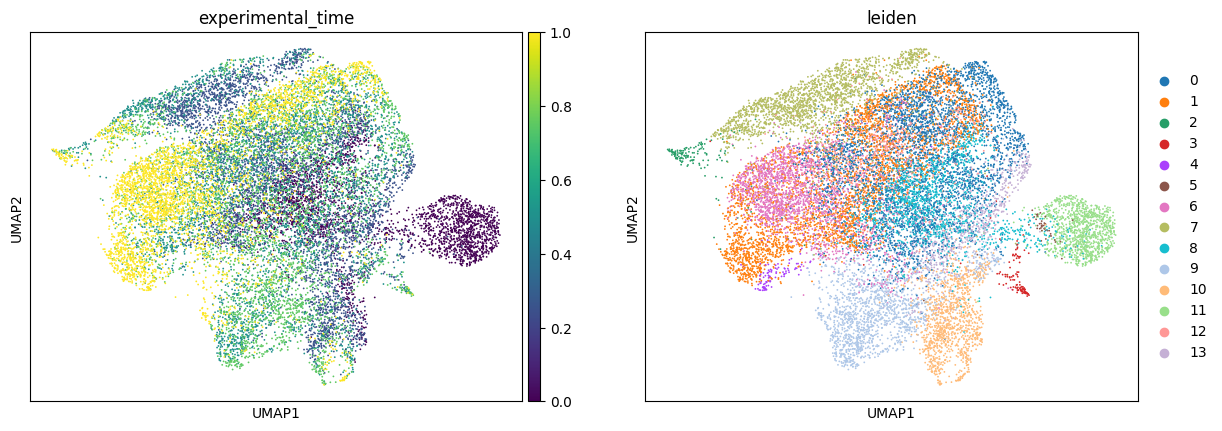

In [15]:
sc.pl.umap(adata_vae_z, color=["experimental_time", "leiden"])
sc.pl.umap(adata_geometric_z, color=["experimental_time", "leiden"])

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


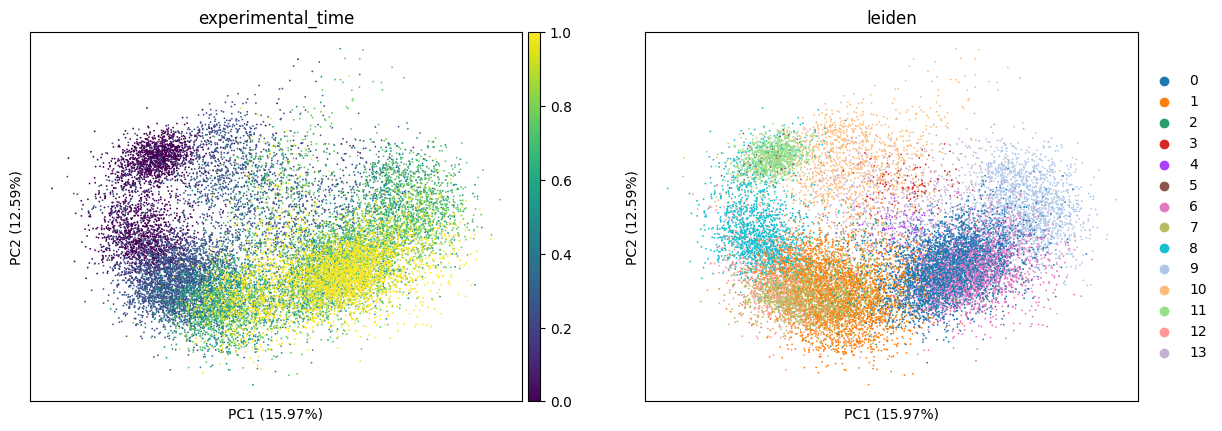

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


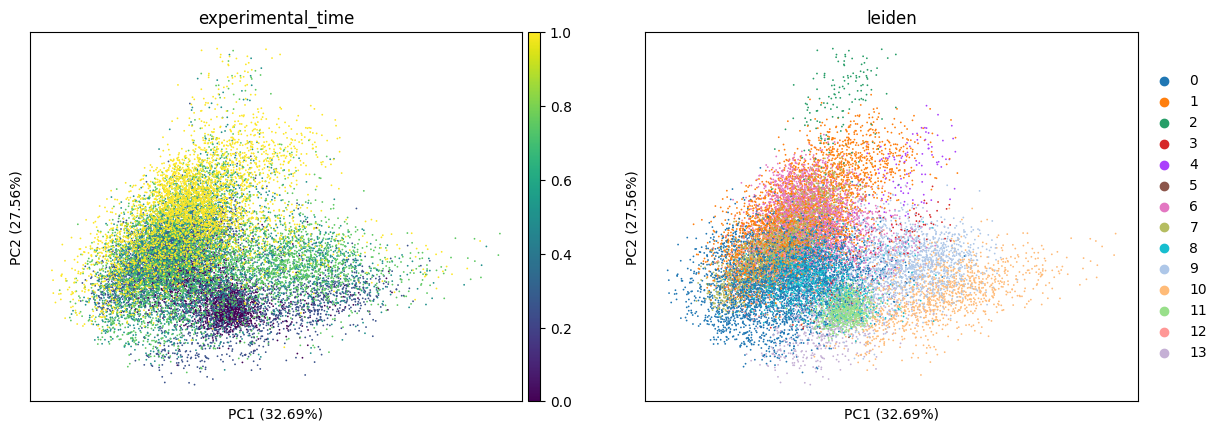

In [16]:
sc.pl.pca(adata_vae_z, color=["experimental_time", "leiden"], annotate_var_explained=True)
sc.pl.pca(adata_geometric_z, color=["experimental_time", "leiden"], annotate_var_explained=True)

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


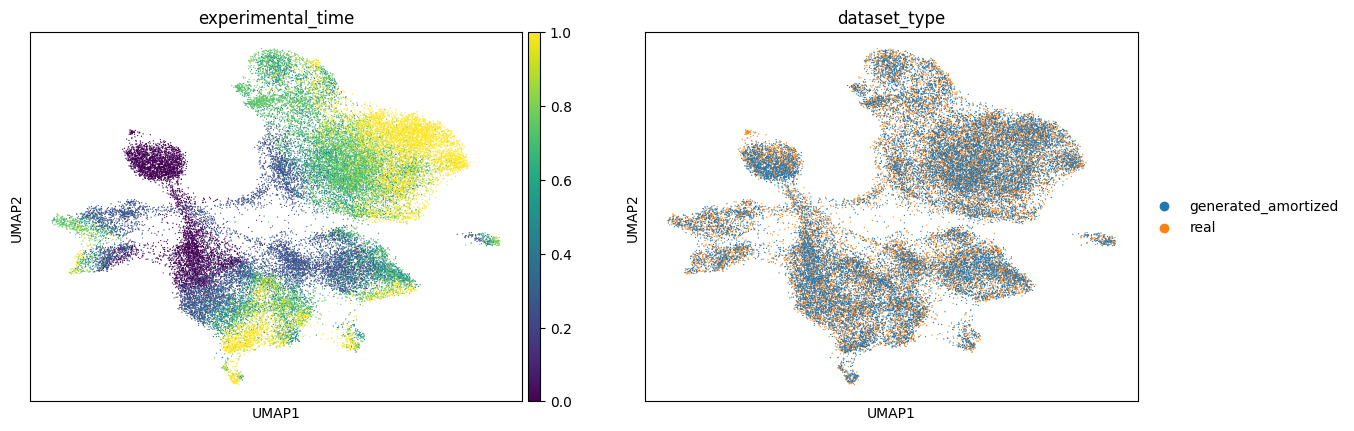

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


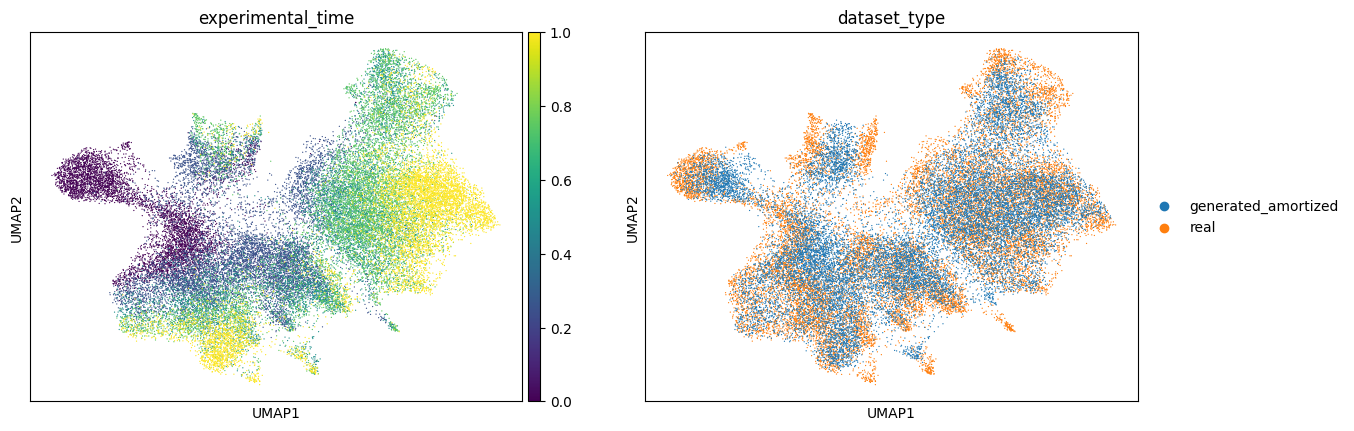

In [20]:
sc.pl.umap(adata_vae_amortized_real, color=["experimental_time", "dataset_type"])
sc.pl.umap(adata_geometric_amortized_real, color=["experimental_time", "dataset_type"])

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


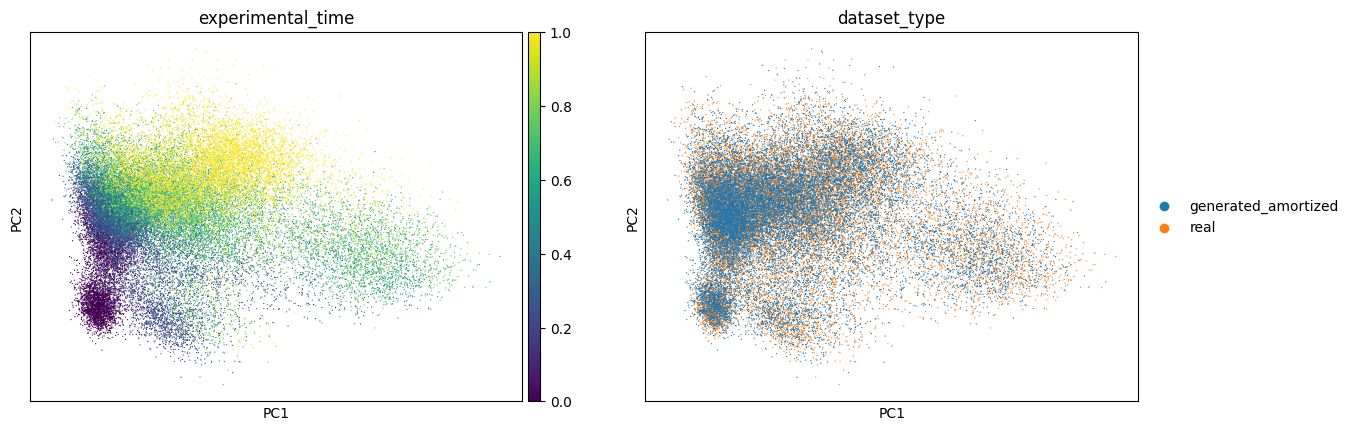

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


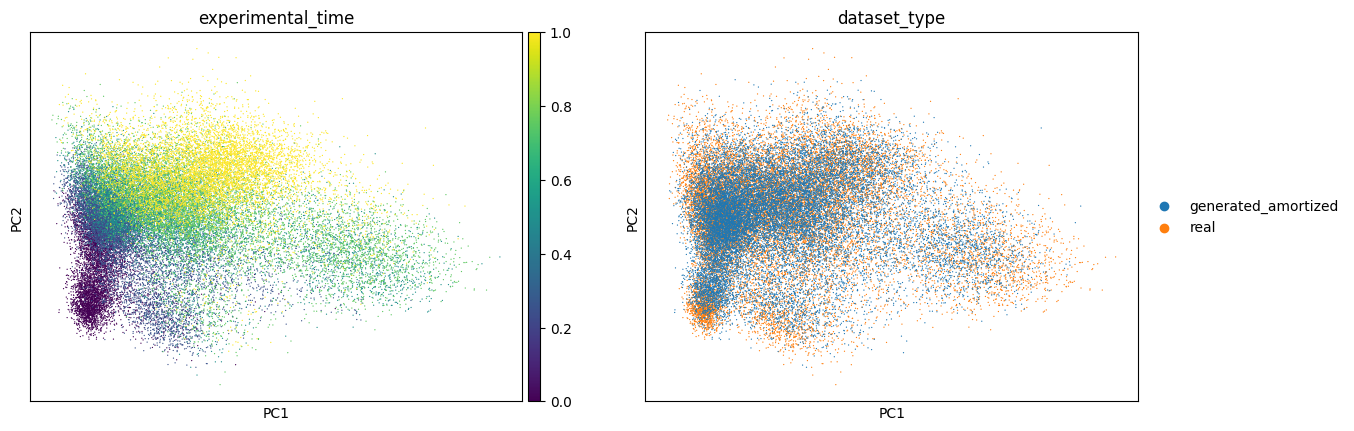

In [21]:
sc.pl.pca(adata_vae_amortized_real, color=["experimental_time", "dataset_type"])
sc.pl.pca(adata_geometric_amortized_real, color=["experimental_time", "dataset_type"])

Check reconstruction umap

In [22]:
from pytorch_lightning import Trainer

trainer_vae = Trainer(inference_mode=False)
trainer_geometric = Trainer(inference_mode=False)

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available

**Save anndata**

In [23]:
PROJECT_FOLDER / "data/eb/flat/"

PosixPath('/nfs/homedirs/pala/scCFM/project_dir/data/eb/flat')

In [24]:
# adata_vae_z.layers["X_latents"] = adata_vae_z.X.copy()
# adata_vae_z.write_h5ad(PROJECT_FOLDER / "data/eb/flat/eb_lib.h5ad")

In [25]:
# adata_geometric_z.layers["X_latents"] = adata_geometric_z.X.copy()
# adata_geometric_z.write_h5ad(PROJECT_FOLDER / "data/eb/flat/eb_flat_lib.h5ad")

**Compare latents**

In [26]:
annot = ["geometric" for _ in range(len(adata_geometric_z))] + ["normal" for _ in range(len(adata_vae_z))]
concat = anndata.concat([adata_geometric_z, adata_vae_z], merge="same")
concat.obs["dataset_type"] = annot

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


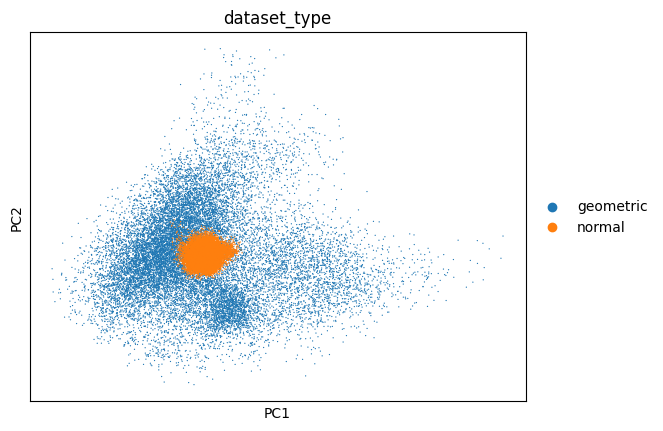

In [27]:
sc.tl.pca(concat)
sc.pl.pca(concat, color="dataset_type")

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


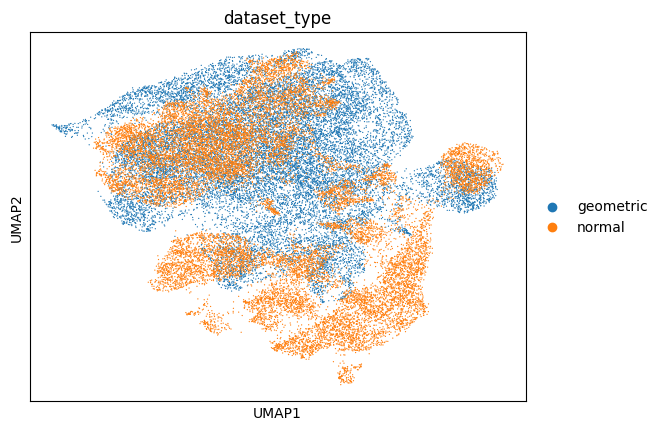

In [28]:
sc.pl.umap(concat, color="dataset_type")

**Latent sizes**

<Axes: xlabel='values', ylabel='Count'>

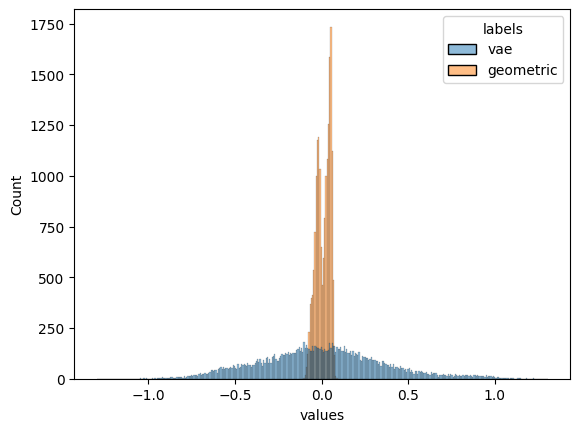

In [29]:
vae_mean_df = make_joint_df([adata_vae_z.X.mean(1), adata_geometric_z.X.mean(1)], 
                              ["vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

**Compare real and generated data**

In [30]:
adata_real = adata_vae_amortized_real[adata_vae_amortized_real.obs['dataset_type']=="real"]
adata_generated_vae = adata_vae_amortized_real[adata_vae_amortized_real.obs['dataset_type']=="generated_amortized"]
adata_generated_geometric = adata_geometric_amortized_real[adata_geometric_amortized_real.obs['dataset_type']=="generated_amortized"]

adata_real.layers["X_norm"] = np.exp(adata_real.X)-1
adata_generated_vae.layers["X_norm"] = np.exp(adata_generated_vae.X)-1
adata_generated_geometric.layers["X_norm"] = np.exp(adata_generated_geometric.X)-1

In [31]:
adata_generated_vae.X

array([[0.       , 0.6931472, 0.       , ..., 0.       , 0.6931472,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 1.3862944,
        0.       ],
       [0.       , 0.       , 0.6931472, ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

<Axes: xlabel='values', ylabel='Count'>

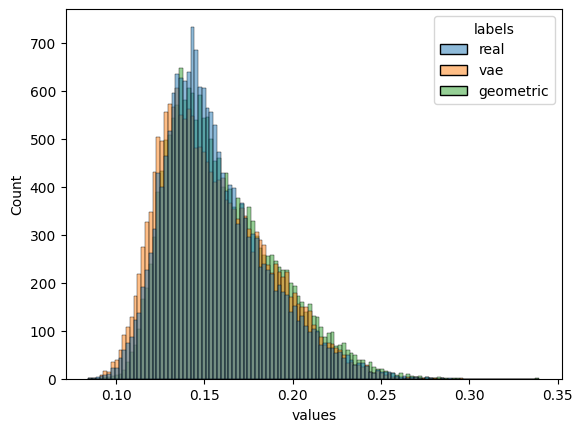

In [32]:
vae_mean_df = make_joint_df([adata_real.X.mean(1), 
                             adata_generated_vae.X.mean(1), 
                             adata_generated_geometric.X.mean(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

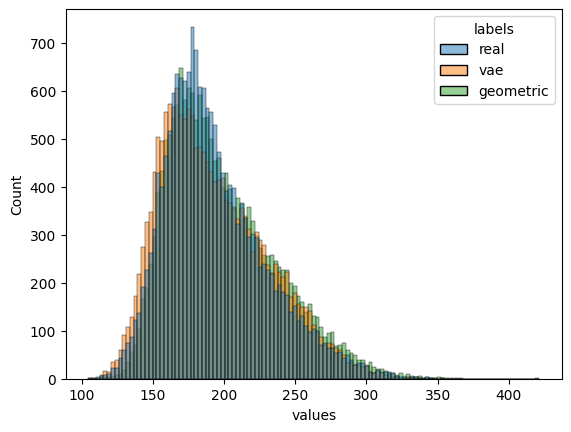

In [33]:
vae_mean_df = make_joint_df([adata_real.X.sum(1), 
                             adata_generated_vae.X.sum(1), 
                             adata_generated_geometric.X.sum(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

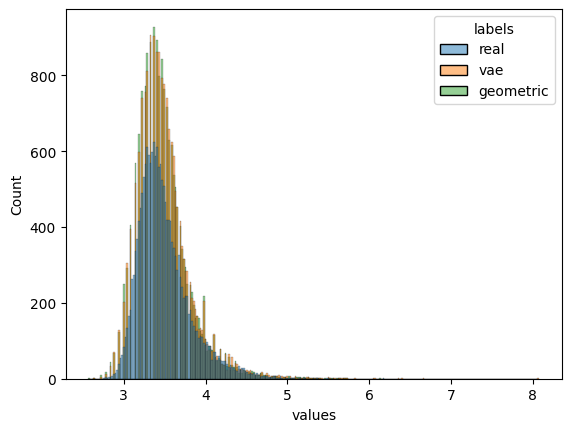

In [34]:
vae_mean_df = make_joint_df([adata_real.X.max(1), 
                             adata_generated_vae.X.max(1), 
                             adata_generated_geometric.X.max(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

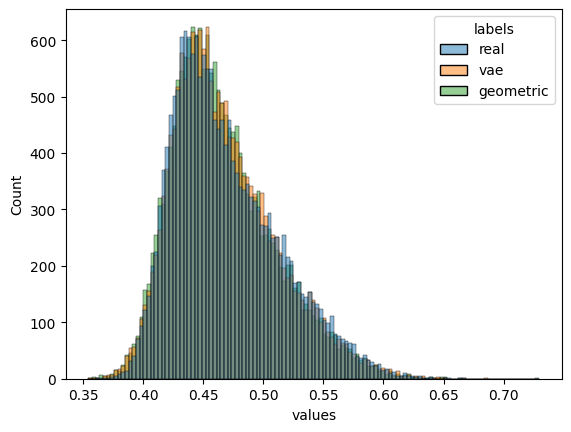

In [35]:
vae_mean_df = make_joint_df([adata_real.X.std(1), 
                             adata_generated_vae.X.std(1), 
                             adata_generated_geometric.X.std(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

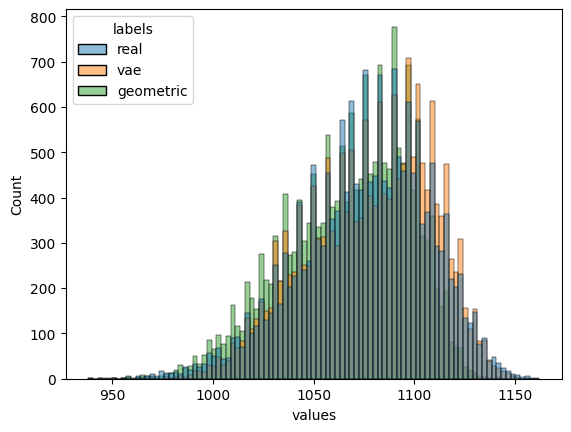

In [36]:
vae_mean_df = make_joint_df([(adata_real.X==0).sum(1), 
                             (adata_generated_vae.X==0).sum(1), 
                             (adata_generated_geometric.X==0).sum(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

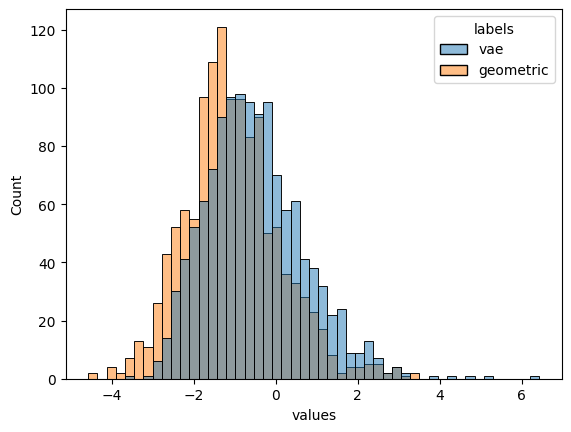

In [37]:
vae_mean_df = make_joint_df([vae.theta.detach().cpu().numpy(), 
                             geometric_vae.theta.detach().cpu().numpy()], 
                              ["vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")